Import Packages

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight

LSTM Base Model

Training fold 1/3
Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.0275 - loss: 3.7496 - val_accuracy: 0.0449 - val_loss: 3.5938
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0436 - loss: 3.6568 - val_accuracy: 0.0381 - val_loss: 3.6488
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.0540 - loss: 3.5761 - val_accuracy: 0.0447 - val_loss: 3.5889
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0974 - loss: 3.3342 - val_accuracy: 0.0746 - val_loss: 3.3766
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1885 - loss: 2.9156 - val_accuracy: 0.0735 - val_loss: 3.5994
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2399 - loss: 2.7410 - val_accuracy: 0.0994 - val_loss: 3.6447
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3590 - loss: 2.2507 - val_accuracy: 0.1105 - val_loss: 3.8086
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4401 - loss:

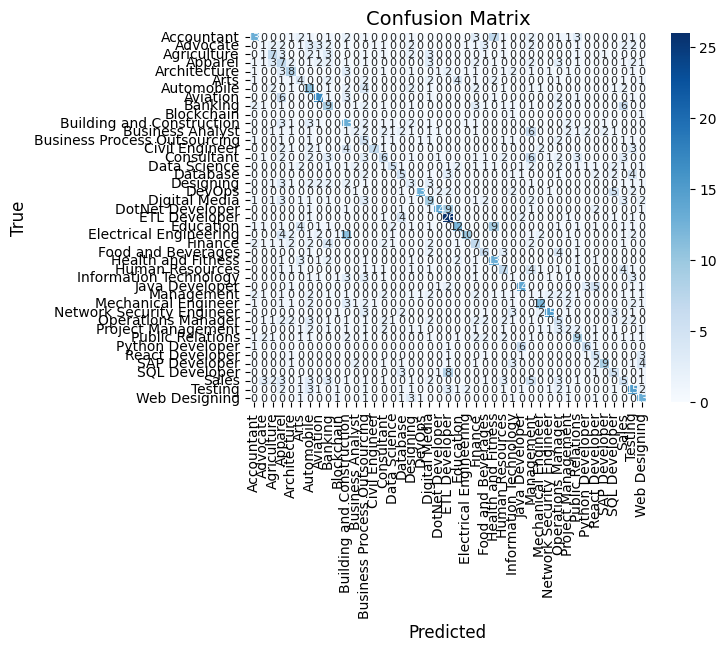

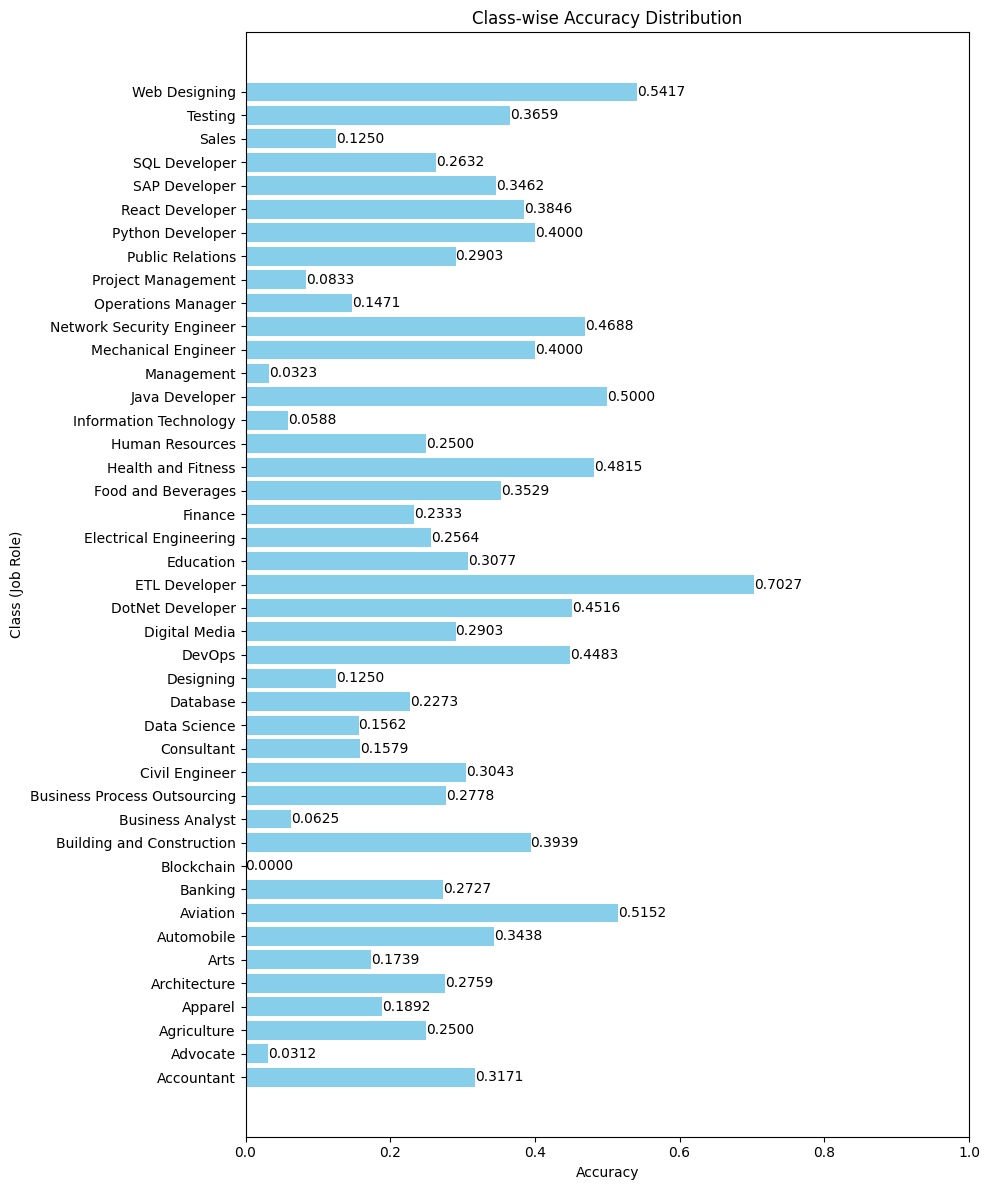

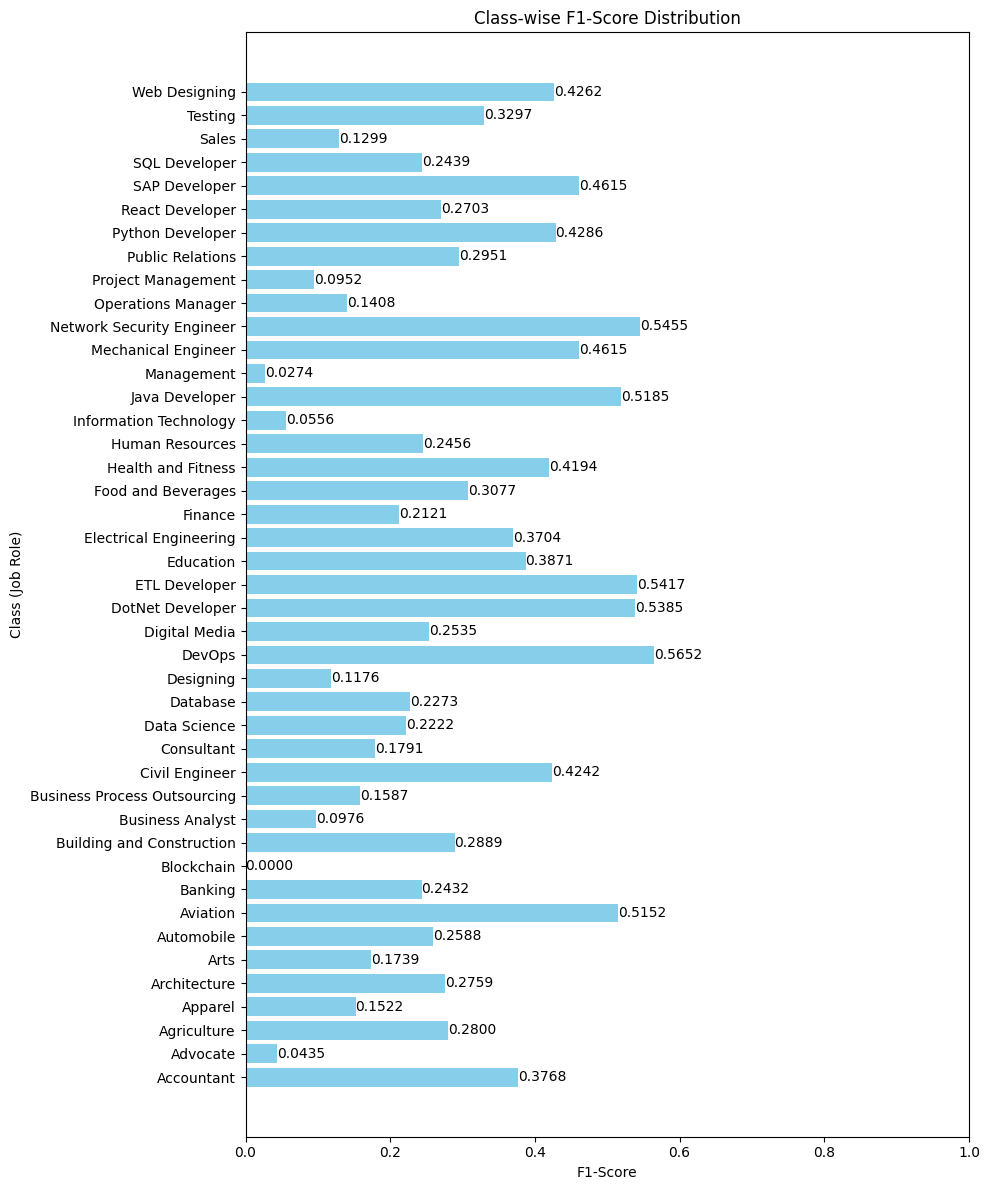

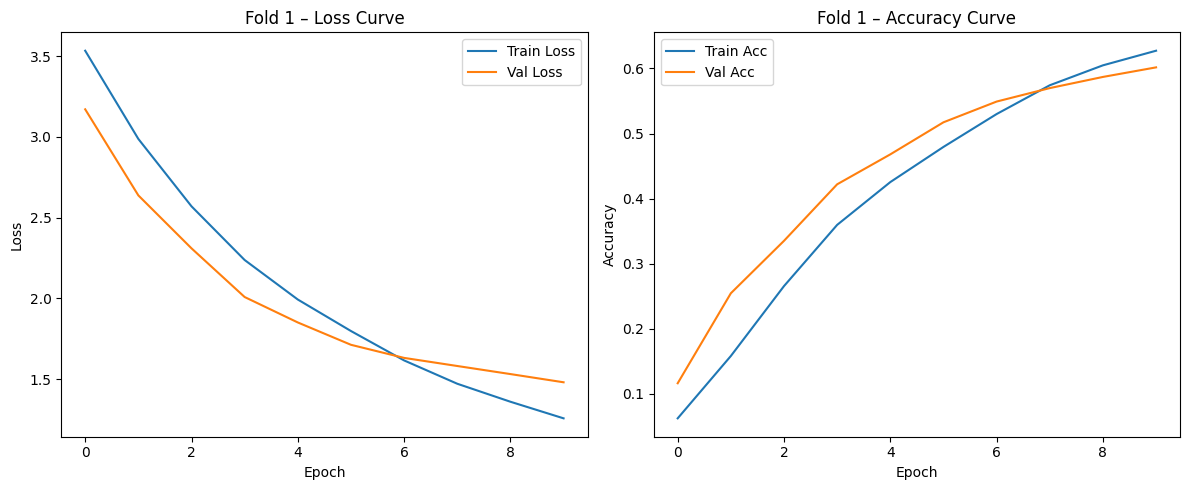

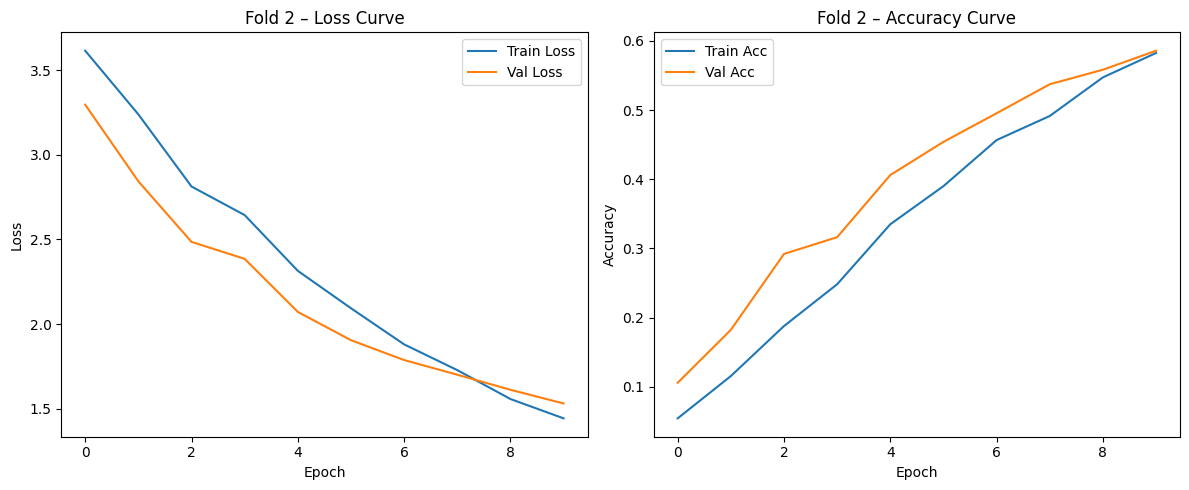

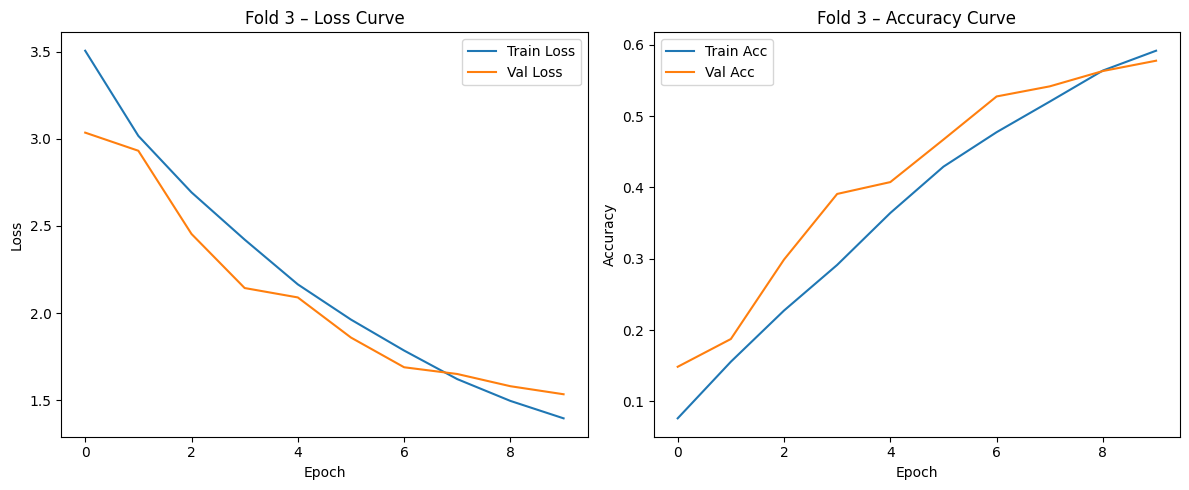

In [ ]:

# Step 1: Load the dataset
df = pd.read_csv('clean_resume_dataset.csv')  # Replace with your dataset path
X = df['clean_text'].values  # Resume text column
y = df['Category'].values  # Job role label column

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Split the data into training and testing sets (90/10 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

# Step 4: Initialize k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation
results_lstm = []  # List to store accuracy results for each fold

# Step 5: Tokenize and pad sequences for LSTM model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Step 6: Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training fold {fold + 1}/{kf.get_n_splits()}")

    # Split data into train and validation for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold_encoded, y_val_fold_encoded = y_train_encoded[train_index], y_train_encoded[val_index]

    # Tokenize and pad the sequences for LSTM
    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)

    # Pad sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=300)
    X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=300)

    # Step 7: Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128))
    model_lstm.add(LSTM(128, dropout=0, recurrent_dropout=0))
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dropout(0))
    model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer (classification)

    optimizer = Adam(learning_rate=1e-3)
    model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Step 8: Train the model
    model_lstm.fit(X_train_pad, y_train_fold_encoded, epochs=15, batch_size=32, validation_data=(X_val_pad, y_val_fold_encoded), verbose=1)

    # Step 9: Evaluate the model on the validation fold
    y_pred = model_lstm.predict(X_val_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

    # Step 10: Calculate the accuracy for this fold
    accuracy = accuracy_score(y_val_fold_encoded, y_pred_classes)
    results_lstm.append(accuracy)

    print(f"Fold {fold + 1} - Accuracy: {accuracy}")

# Step 11: Calculate average accuracy across all folds
avg_accuracy_lstm = np.mean(results_lstm)
print(f"Average accuracy across all folds for LSTM: {avg_accuracy_lstm}")

# Optional: Evaluate the model on the test set (final evaluation after cross-validation)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=300)
y_pred_test = model_lstm.predict(X_test_pad)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

print("\n--- Final Test Set Evaluation ---")
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test_classes))
print("\nTest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_))

# -------------------------------------------------------
# FINAL EVALUATION
# -------------------------------------------------------
total_training_time = time.time() - total_start_time

print(f"\nAverage accuracy across folds: {np.mean(results_lstm):.4f}")
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Training time per fold: {[round(t,2) for t in fold_times]}")

# --- Test prediction ---
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding="post", maxlen=300)

y_pred_test = model_lstm.predict(X_test_pad)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

print("\n--- Final Test Set Evaluation ---")
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test_classes))
print("\nTest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_))

# -------------------------------------------------------
# Confusion Matrix
# -------------------------------------------------------
cm = confusion_matrix(y_test_encoded, y_pred_test_classes)
print("\nConfusion Matrix:")
print(cm)

# -------------------------------------------------------
# Plot Confusion Matrix
# -------------------------------------------------------
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 8}  # Adjust the font size of the annotations
)
plt.title("Confusion Matrix", fontsize=14)  # Optional: Adjust the title font size
plt.xlabel("Predicted", fontsize=12)  # Optional: Adjust x-axis label font size
plt.ylabel("True", fontsize=12)  # Optional: Adjust y-axis label font size
plt.xticks(fontsize=10)  # Adjust the font size of the x-axis ticks
plt.yticks(fontsize=10)  # Adjust the font size of the y-axis ticks
plt.show()

# -------------------------------------------------------
# Plot Accuracy per Class
# -------------------------------------------------------
class_accuracies = {}
for idx, class_name in enumerate(label_encoder.classes_):
    class_acc = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    class_accuracies[class_name] = class_acc

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise Accuracy Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Plot F1-Score per Class
# -------------------------------------------------------
report = classification_report(
    y_test_encoded, y_pred_test_classes,
    target_names=label_encoder.classes_,
    output_dict=True
)

class_f1 = {cls: report[cls]['f1-score'] for cls in label_encoder.classes_}

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_f1.keys()), list(class_f1.values()), color='skyblue')
plt.xlabel('F1-Score')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise F1-Score Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# ABLATION STUDY: TRAINING vs VALIDATION LOSS/ACC
# -------------------------------------------------------
for i, hist in enumerate(fold_histories):
    plt.figure(figsize=(12,5))

    # LOSS
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"Fold {i+1} – Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ACCURACY
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"Fold {i+1} – Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()



biLSTM

Training fold 1/3
Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.0391 - loss: 3.7172 - val_accuracy: 0.0972 - val_loss: 3.4148
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.1324 - loss: 3.1521 - val_accuracy: 0.2320 - val_loss: 2.8352
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.3693 - loss: 2.2099 - val_accuracy: 0.3754 - val_loss: 2.4465
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6285 - loss: 1.3239 - val_accuracy: 0.4340 - val_loss: 2.4436
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8175 - loss: 0.7266 - val_accuracy: 0.4421 - val_loss: 2.7074
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9108 - loss: 0.3829 - val_accuracy: 0.4582 - val_loss: 2.9479
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9511 - loss: 0.2163 - val_accuracy: 0.4656 - val_loss: 3.2102
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9792 - loss

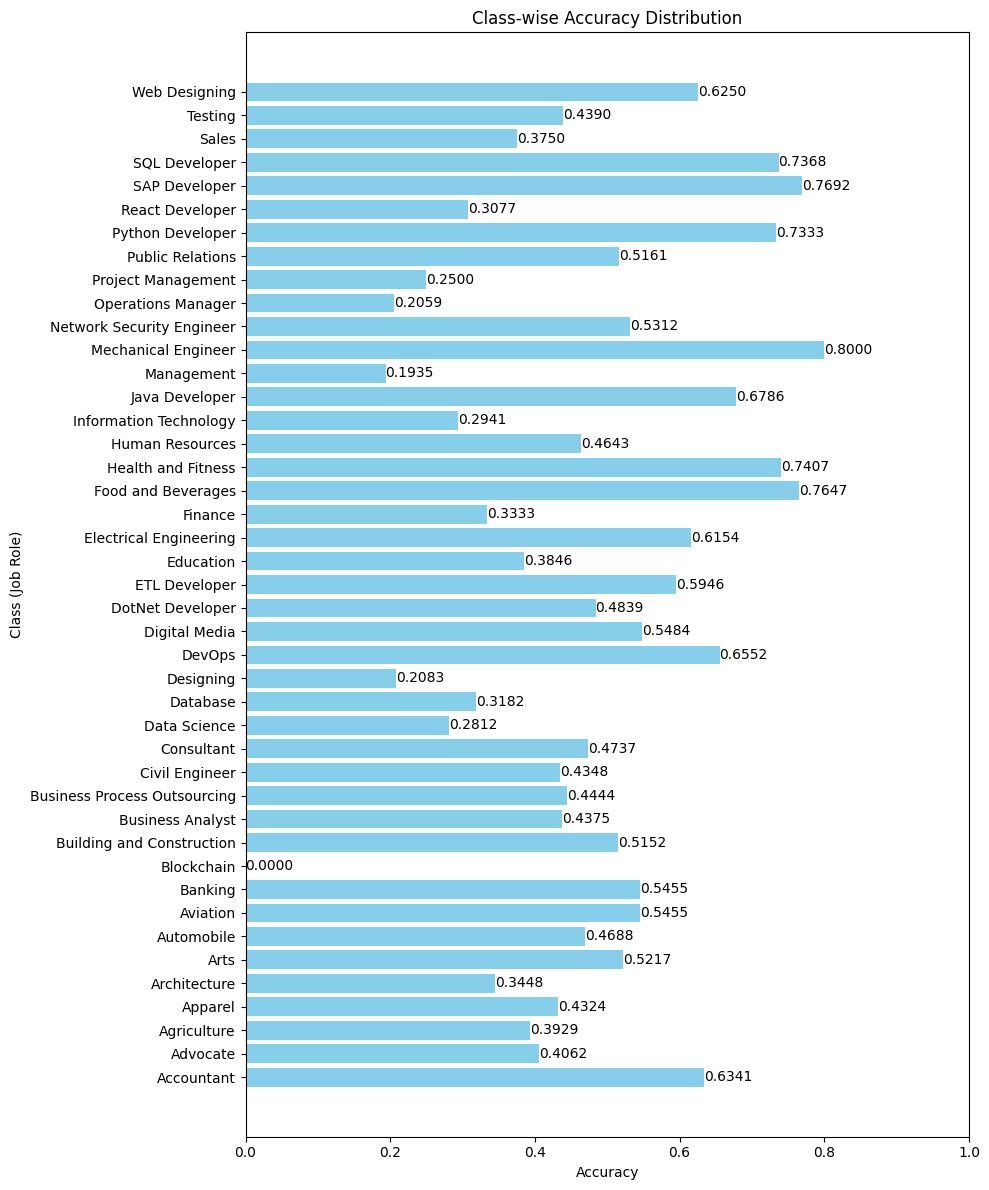

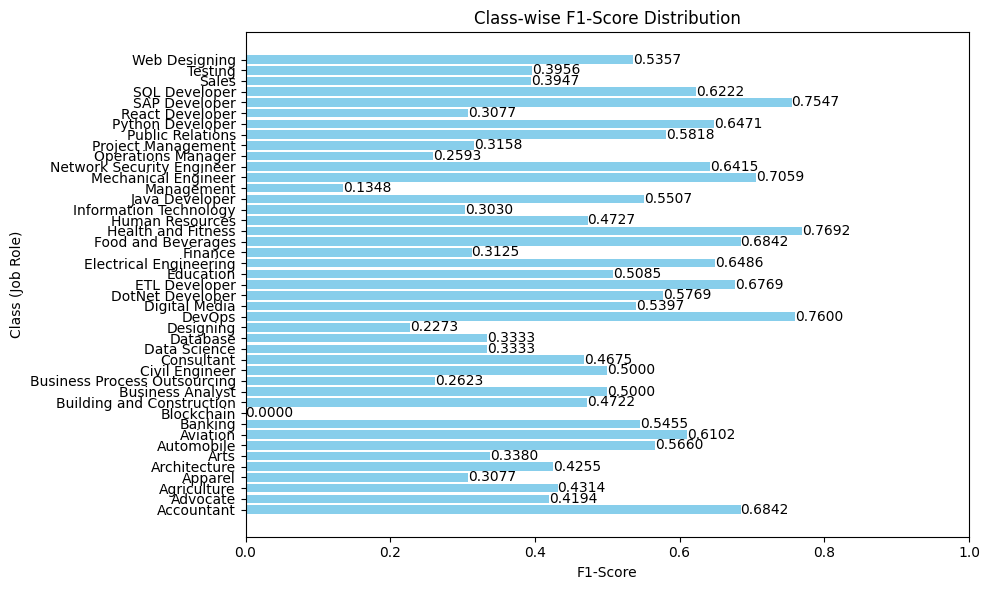

In [ ]:
# Step 1: Load the dataset
df = pd.read_csv('clean_resume_dataset.csv')  # Replace with your dataset path
X = df['clean_text'].values  # Resume text column
y = df['Category'].values  # Job role label column

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Split the data into training and testing sets (90/10 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

# Step 4: Initialize k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation
results_lstm = []  # List to store accuracy results for each fold

# Step 5: Tokenize and pad sequences for LSTM model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Step 6: Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training fold {fold + 1}/{kf.get_n_splits()}")

    # Split data into train and validation for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold_encoded, y_val_fold_encoded = y_train_encoded[train_index], y_train_encoded[val_index]

    # Tokenize and pad the sequences for LSTM
    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)

    # Pad sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=300)
    X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=300)

    # Step 7: Build the Bidirectional LSTM model
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128))
    model_lstm.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0)))  # Bidirectional LSTM
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dropout(0))
    model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer (classification)

    optimizer = Adam(learning_rate=1e-3)  # Adjust the learning rate
    model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Step 8: Train the model
    model_lstm.fit(X_train_pad, y_train_fold_encoded, epochs=15, batch_size=32, validation_data=(X_val_pad, y_val_fold_encoded), verbose=1)

    # Step 9: Evaluate the model on the validation fold
    y_pred = model_lstm.predict(X_val_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

    # Step 10: Calculate the accuracy for this fold
    accuracy = accuracy_score(y_val_fold_encoded, y_pred_classes)
    results_lstm.append(accuracy)

    print(f"Fold {fold + 1} - Accuracy: {accuracy}")

# Step 11: Calculate average accuracy across all folds
avg_accuracy_lstm = np.mean(results_lstm)
print(f"Average accuracy across all folds for LSTM: {avg_accuracy_lstm}")

# Step 12: Evaluate the model on the test set (final evaluation after cross-validation)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=300)
y_pred_test = model_lstm.predict(X_test_pad)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test_encoded, y_pred_test_classes)
print(f"\n--- Final Test Set Evaluation ---")
print("Test Accuracy:", test_accuracy)
print("\nTest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_))

# Step 13: Extract class-wise accuracy from the classification report
report = classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_, output_dict=True)

# Step 14: Diagrams
from sklearn.metrics import confusion_matrix

# Step 1: Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_test_classes)
# cm[i, j] = number of samples with true class i predicted as class j

# Step 2: Calculate class-wise accuracy
class_accuracies = {}
for idx, class_name in enumerate(label_encoder.classes_):
    # Accuracy = correct predictions / total samples for that class
    class_accuracy = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    class_accuracies[class_name] = class_accuracy

# Step 3: Plot horizontal bar chart with numbers
plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise Accuracy Distribution')
plt.xlim(0, 1)

# Step 4: Add the accuracy values on top of each bar
for bar in bars:
    width = bar.get_width()  # Get the width of each bar (accuracy value)
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}',
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Extract f1-score for each class
class_accuracies = {class_name: report[class_name]['f1-score'] for class_name in label_encoder.classes_}

# Step 14: Plot class-wise F1-score distribution with numbers
plt.figure(figsize=(10, 6))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color='skyblue')
plt.xlabel('F1-Score')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise F1-Score Distribution')
plt.xlim(0, 1)  # F1-score ranges from 0 to 1

# Add the F1-score values on top of each bar
for bar in bars:
    width = bar.get_width()  # Get the width of each bar (F1-score value)
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}',
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()


BiLSTM with GloVe Embedding


In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -l glove.6B.100d.txt

--2025-11-16 12:13:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-16 12:13:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-16 12:13:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

BiLSTM with GloVe Embeddings (no class-weighted trainings)

Loading GloVe...
GloVe Loaded!

Training fold 1/3
Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.0486 - loss: 3.6501 - val_accuracy: 0.1497 - val_loss: 3.0663
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.1508 - loss: 3.0848 - val_accuracy: 0.2407 - val_loss: 2.6623
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.2600 - loss: 2.6265 - val_accuracy: 0.3319 - val_loss: 2.3363
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.3305 - loss: 2.3476 - val_accuracy: 0.4195 - val_loss: 2.0593
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.4024 - loss: 2.1083 - val_accuracy: 0.4509 - val_loss: 1.8957
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.4571 - loss: 1.8849 - val_accuracy: 0.5086 - val_loss: 1.7575
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5173 - loss: 1.6988 - val_accuracy: 0.5554 - val_loss: 1.6369
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


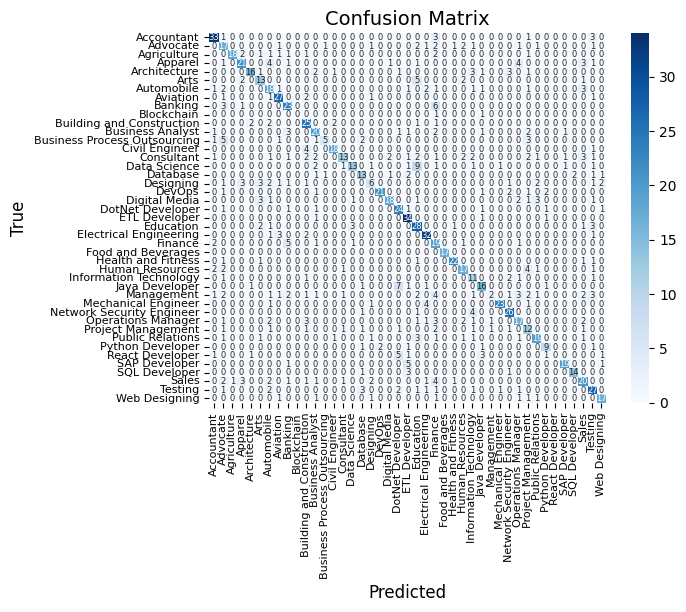

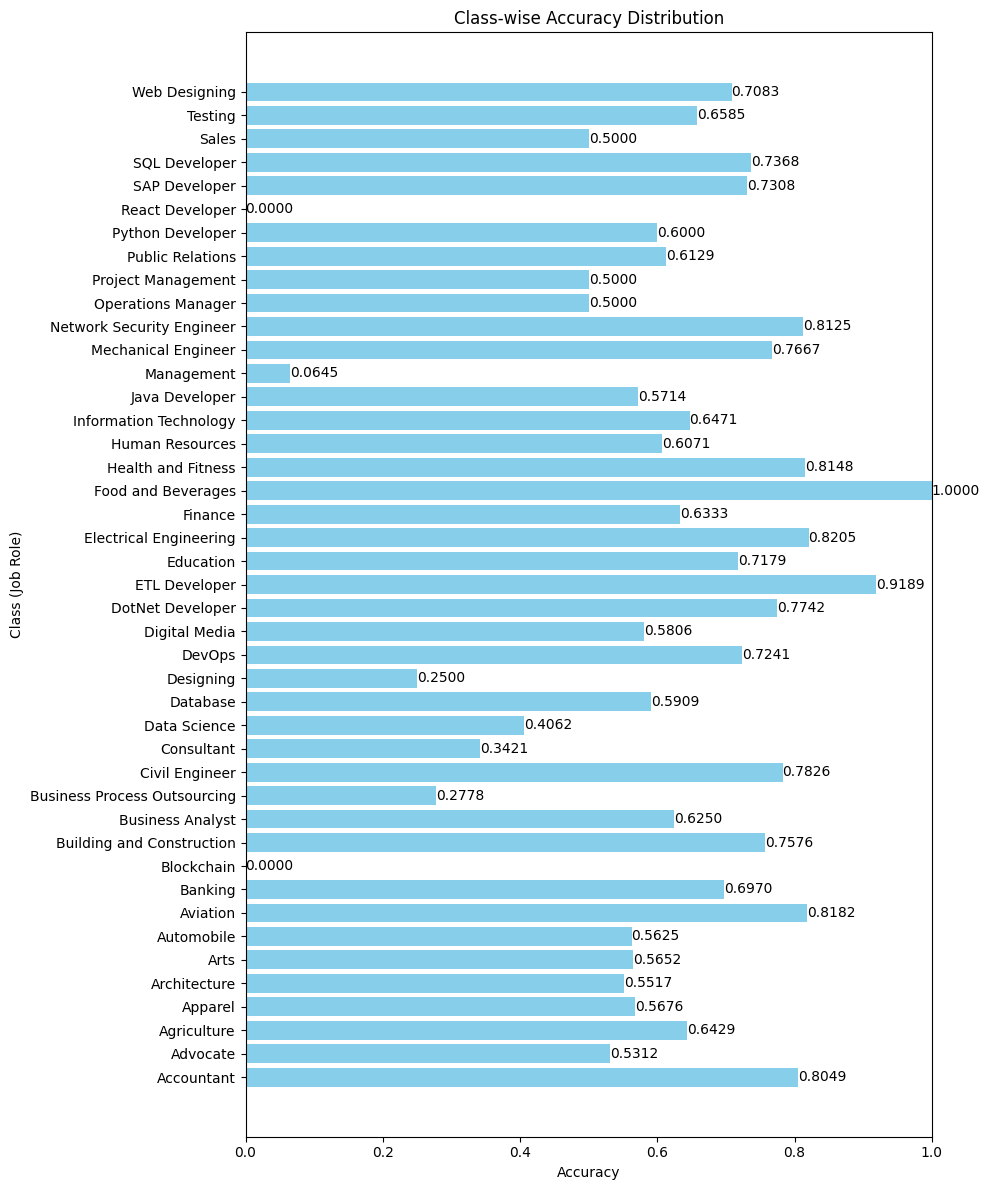

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


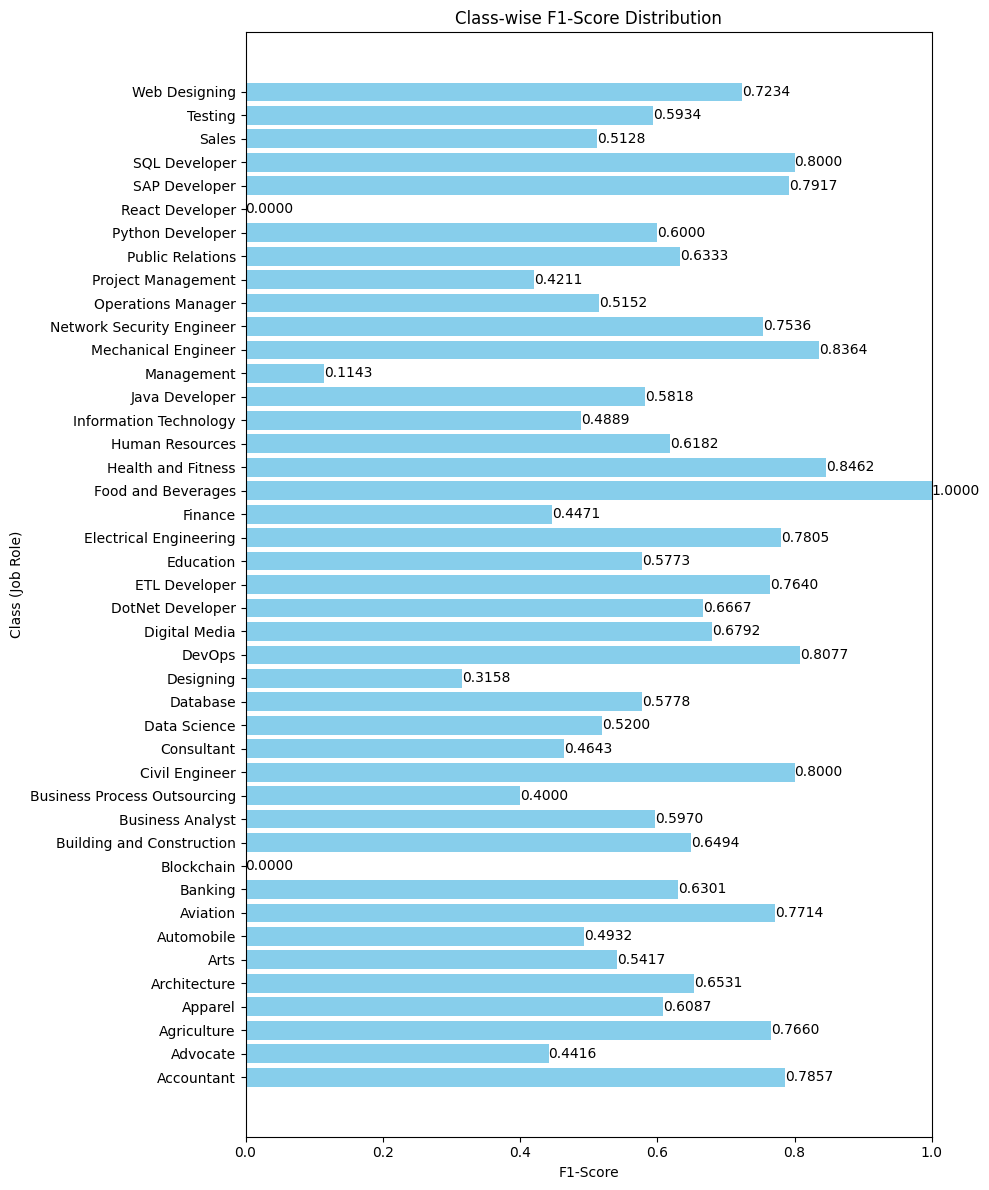

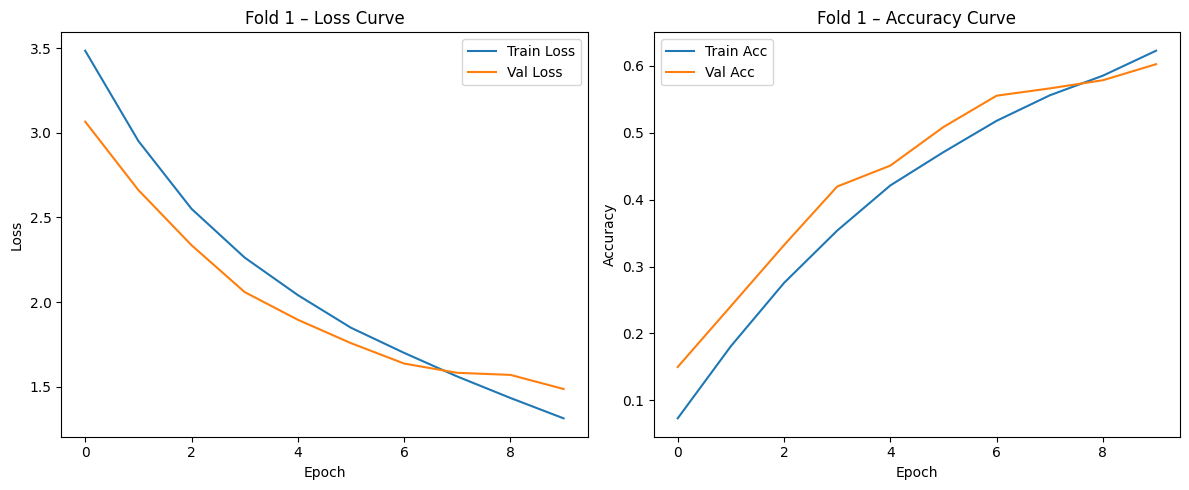

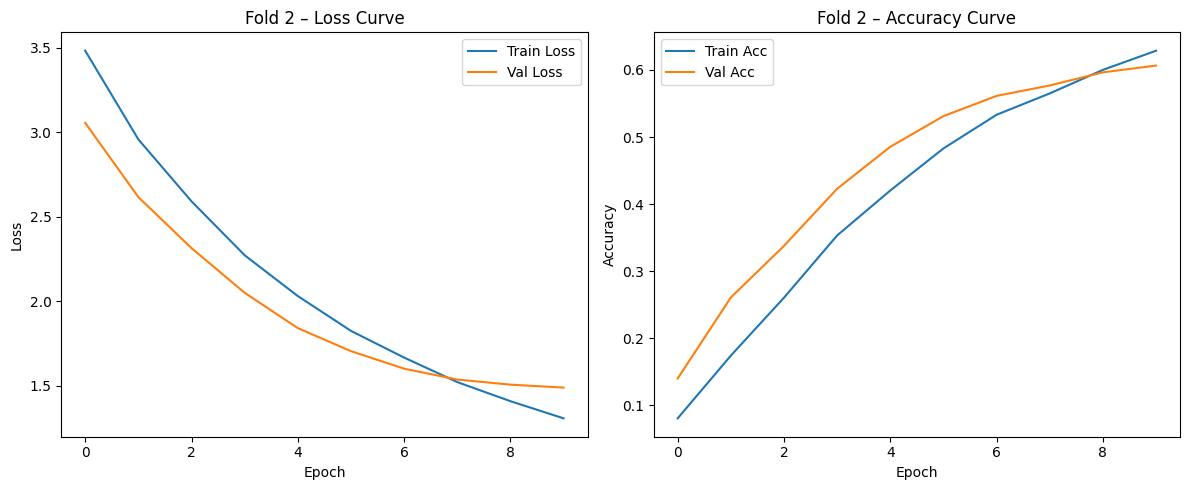

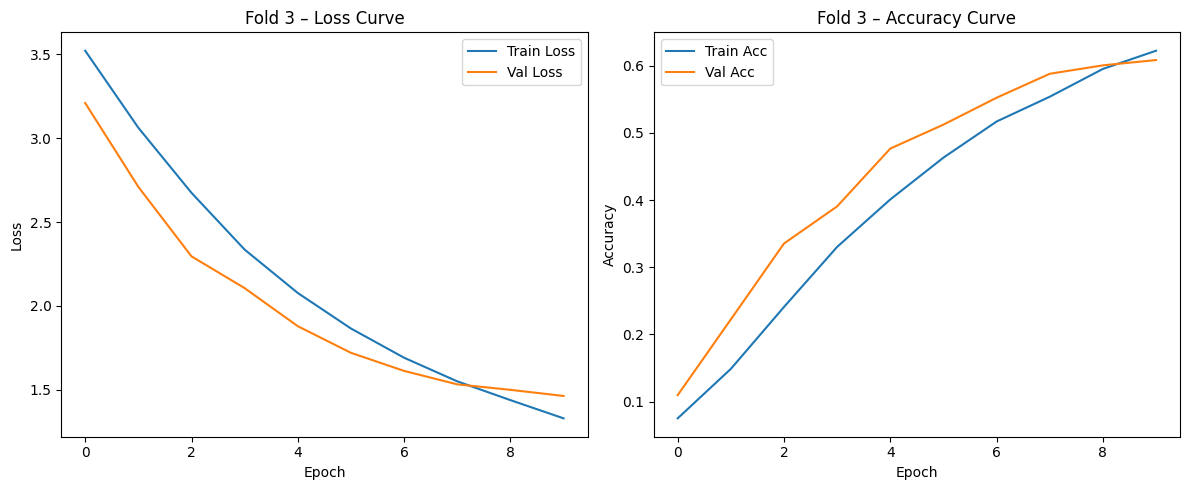

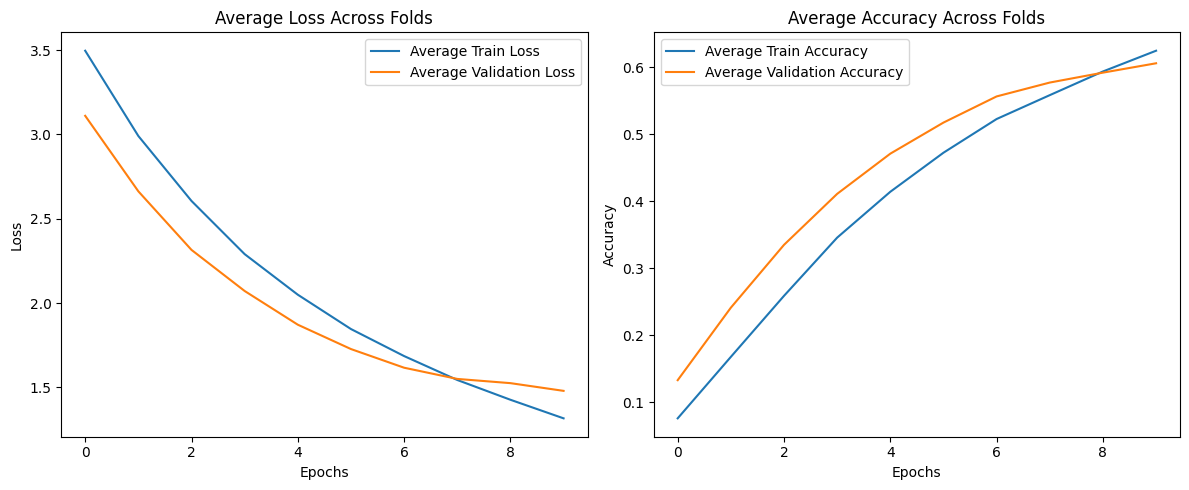

In [ ]:
# -------------------------------------------------------
# STEP 1: Load dataset
# -------------------------------------------------------
df = pd.read_csv('clean_resume_dataset.csv')
X = df['clean_text'].fillna('').astype(str).values
y = df['Category'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42
)

# -------------------------------------------------------
# STEP 2: Tokenizer
# -------------------------------------------------------
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# -------------------------------------------------------
# STEP 3: Load GloVe Embeddings
# -------------------------------------------------------
embedding_dim = 100
embedding_index = {}

print("Loading GloVe...")
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs
print("GloVe Loaded!")

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vec = embedding_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

# -------------------------------------------------------
# STEP 4: K-Fold Cross Validation
# -------------------------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results_lstm = []

# Track time + histories
total_start_time = time.time()
fold_times = []
fold_histories = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nTraining fold {fold + 1}/3")

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)
    X_train_pad = pad_sequences(X_train_seq, padding="post", maxlen=300)
    X_val_pad = pad_sequences(X_val_seq, padding="post", maxlen=300)

    # Build model
    model_lstm = Sequential()
    model_lstm.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False
        )
    )
    model_lstm.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0)))
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dropout(0.1))
    model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model_lstm.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    # ---- Track fold time ----
    fold_start = time.time()

    # Train without class weights
    history = model_lstm.fit(
        X_train_pad, y_train_fold,
        epochs=10,
        batch_size=16,
        validation_data=(X_val_pad, y_val_fold),
        verbose=1
    )

    fold_end = time.time()
    fold_times.append(fold_end - fold_start)
    fold_histories.append(history)

    # Predict fold validation
    y_pred = model_lstm.predict(X_val_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_val_fold, y_pred_classes)
    results_lstm.append(acc)
    print(f"Fold {fold + 1} - Accuracy: {acc}")

# -------------------------------------------------------
# FINAL EVALUATION
# -------------------------------------------------------
total_training_time = time.time() - total_start_time

print(f"\nAverage accuracy across folds: {np.mean(results_lstm):.4f}")
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Training time per fold: {[round(t,2) for t in fold_times]}")

# --- Test prediction ---
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding="post", maxlen=300)

y_pred_test = model_lstm.predict(X_test_pad)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

print("\n--- Final Test Set Evaluation ---")
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test_classes))
print("\nTest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_))

# -------------------------------------------------------
# Confusion Matrix
# -------------------------------------------------------
cm = confusion_matrix(y_test_encoded, y_pred_test_classes)
print("\nConfusion Matrix:")
print(cm)

# -------------------------------------------------------
# Plot Confusion Matrix
# -------------------------------------------------------
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 6}  # Adjust the font size of the annotations
)
plt.title("Confusion Matrix", fontsize=14)  # Optional: Adjust the title font size
plt.xlabel("Predicted", fontsize=12)  # Optional: Adjust x-axis label font size
plt.ylabel("True", fontsize=12)  # Optional: Adjust y-axis label font size
plt.xticks(fontsize=8)  # Adjust the font size of the x-axis ticks
plt.yticks(fontsize=8)  # Adjust the font size of the y-axis ticks
plt.show()

# -------------------------------------------------------
# Plot Accuracy per Class
# -------------------------------------------------------
class_accuracies = {}
for idx, class_name in enumerate(label_encoder.classes_):
    class_acc = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    class_accuracies[class_name] = class_acc

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise Accuracy Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Plot F1-Score per Class
# -------------------------------------------------------
report = classification_report(
    y_test_encoded, y_pred_test_classes,
    target_names=label_encoder.classes_,
    output_dict=True
)

class_f1 = {cls: report[cls]['f1-score'] for cls in label_encoder.classes_}

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_f1.keys()), list(class_f1.values()), color='skyblue')
plt.xlabel('F1-Score')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise F1-Score Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# ABLATION STUDY: TRAINING vs VALIDATION LOSS/ACC
# -------------------------------------------------------
for i, hist in enumerate(fold_histories):
    plt.figure(figsize=(12,5))

    # LOSS
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"Fold {i+1} – Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ACCURACY
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"Fold {i+1} – Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# Average Loss and Accuracy across Folds
# -------------------------------------------------------
avg_train_loss = []
avg_val_loss = []
avg_train_acc = []
avg_val_acc = []

# For each fold's history, append the corresponding losses and accuracies
for history in fold_histories:
    avg_train_loss.append(history.history['loss'])
    avg_val_loss.append(history.history['val_loss'])
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

# Convert to numpy arrays for easy manipulation
avg_train_loss = np.mean(np.array(avg_train_loss), axis=0)
avg_val_loss = np.mean(np.array(avg_val_loss), axis=0)
avg_train_acc = np.mean(np.array(avg_train_acc), axis=0)
avg_val_acc = np.mean(np.array(avg_val_acc), axis=0)

# -------------------------------------------------------
# Plotting Average Loss and Accuracy across all folds
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Average Train Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Average Train Accuracy')
plt.plot(avg_val_acc, label='Average Validation Accuracy')
plt.title("Average Accuracy Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



LSTM Bidirectional with GloVe Embedding and Class Weights

Loading GloVe...
GloVe Loaded!

Class weights applied:
{0: np.float64(0.8657291011942174), 1: np.float64(0.9894046870791057), 2: np.float64(1.2877176580577305), 3: np.float64(0.9184796199049763), 4: np.float64(0.9284630940343782), 5: np.float64(1.109332527937179), 6: np.float64(0.9490956072351421), 7: np.float64(0.8716184148077836), 8: np.float64(0.9894046870791057), 9: np.float64(5.570778564206269), 10: np.float64(0.8485291852764516), 11: np.float64(0.8991432068543451), 12: np.float64(1.4315967259971418), 13: np.float64(0.8806041716614721), 14: np.float64(0.837437300501596), 15: np.float64(1.0168881506090808), 16: np.float64(1.1338752829800371), 17: np.float64(1.1491292105537596), 18: np.float64(1.1338752829800371), 19: np.float64(0.8293068412734251), 20: np.float64(0.9670030715225977), 21: np.float64(1.1389147286821706), 22: np.float64(0.7342573465715999), 23: np.float64(0.7860607789984306), 24: np.float64(0.8513482191145794), 25: np.float64(2.001998546511628), 26: np.float64(0.93524

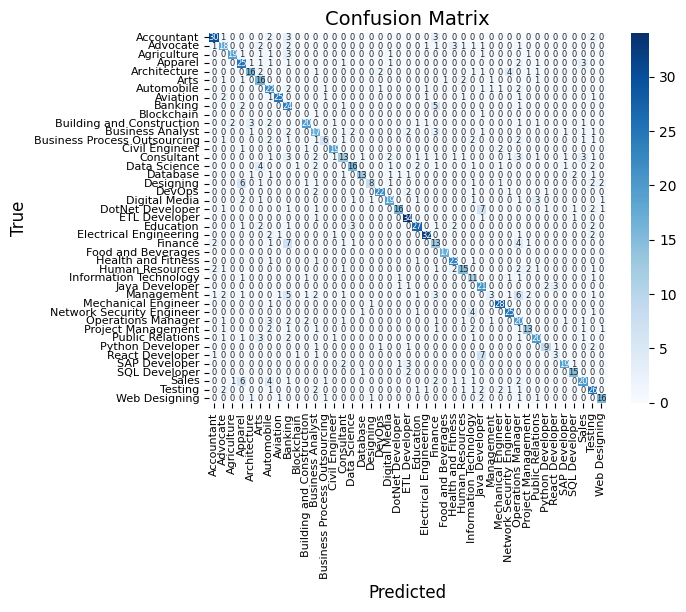

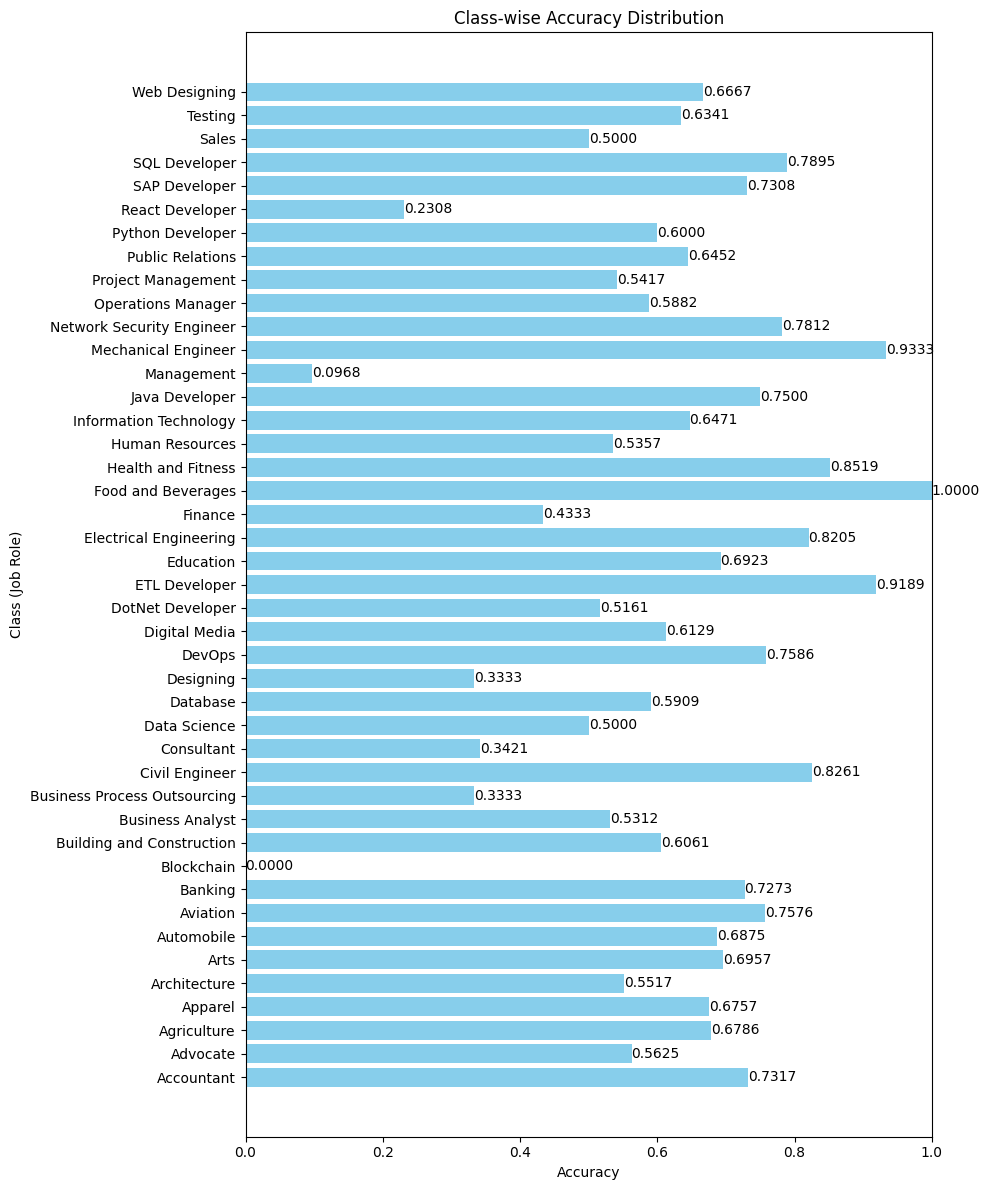

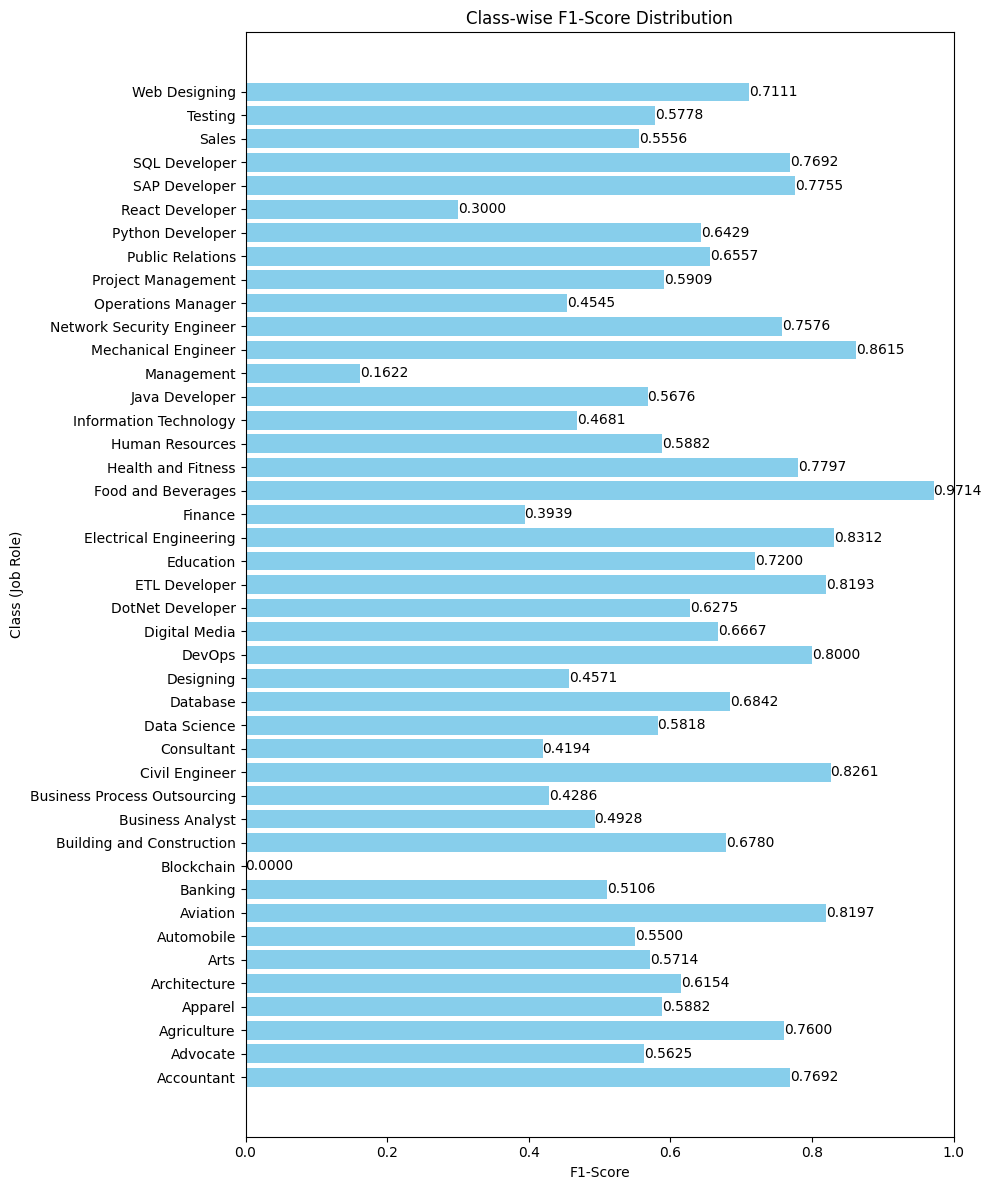

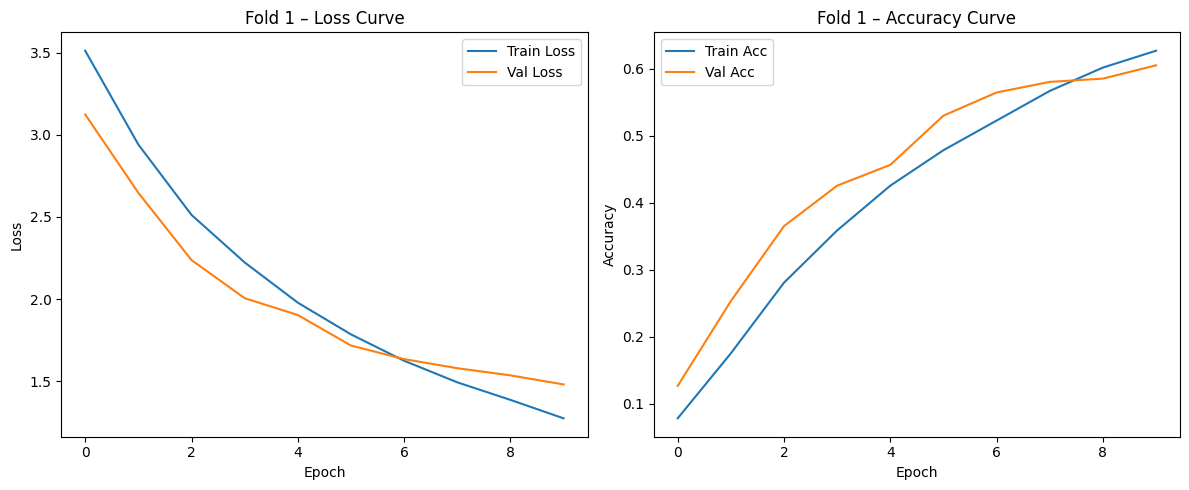

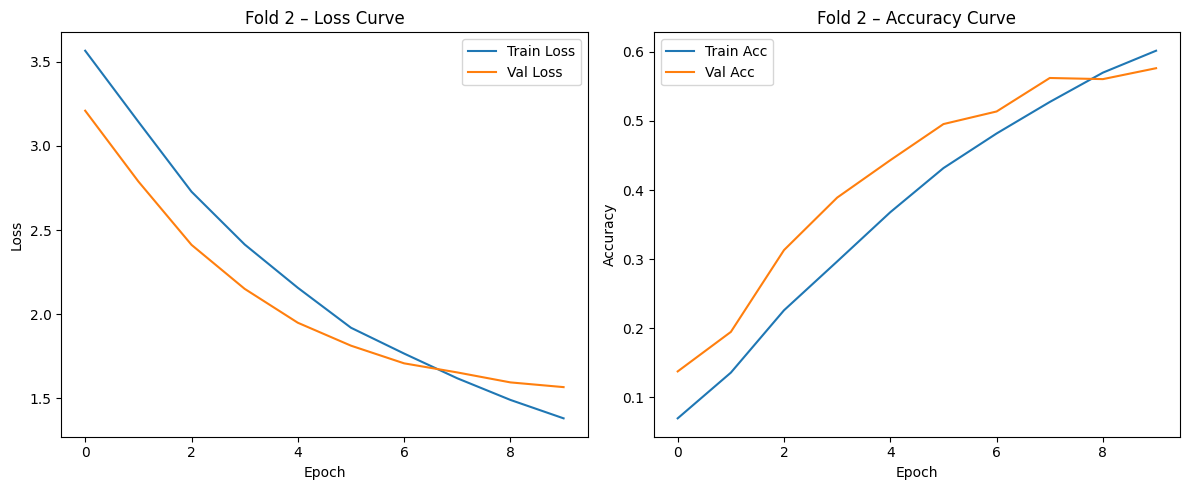

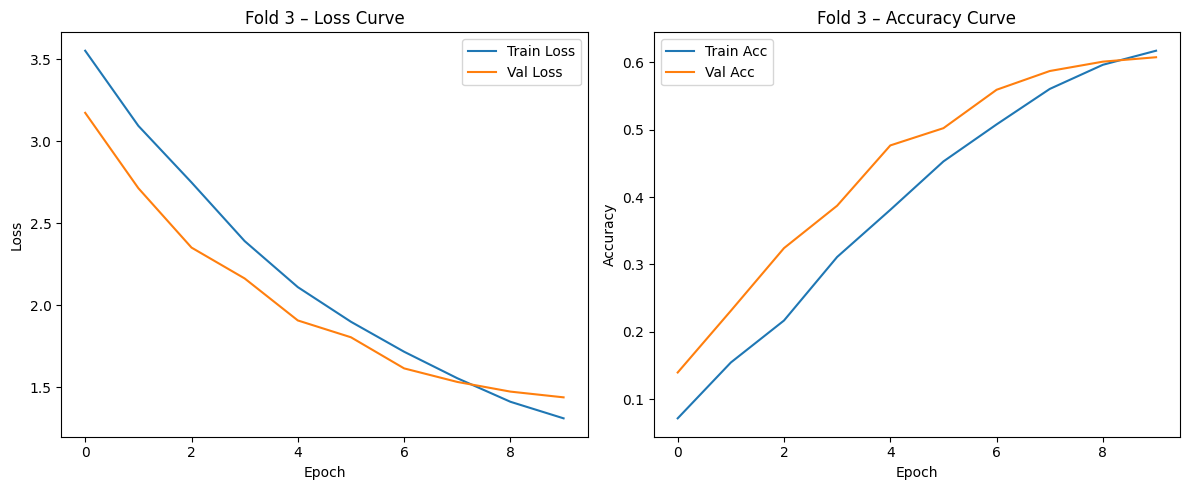

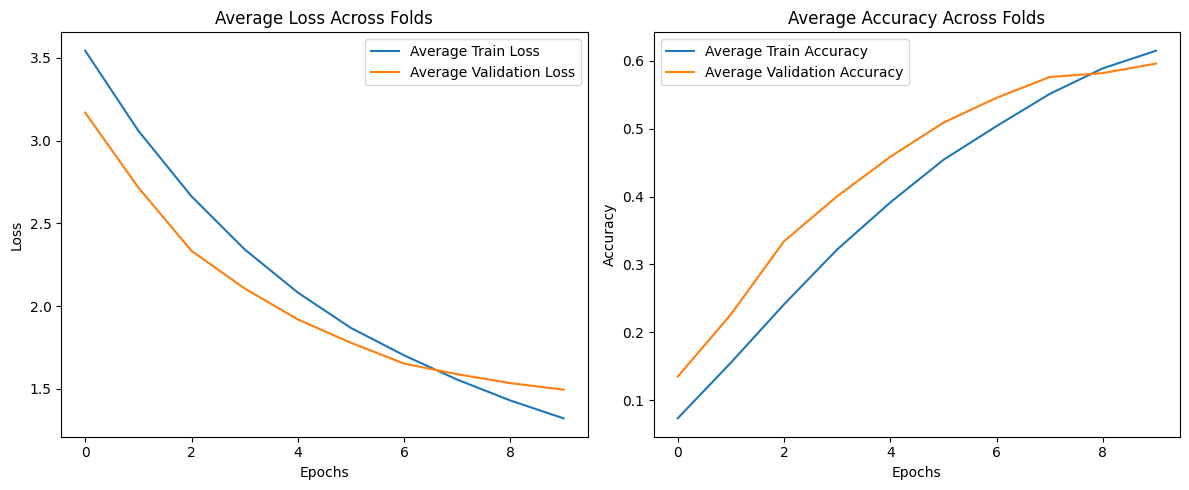

In [ ]:
# -------------------------------------------------------
# STEP 1: Load dataset
# -------------------------------------------------------
df = pd.read_csv('clean_resume_dataset.csv')
X = df['clean_text'].fillna('').astype(str).values
y = df['Category'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42
)

# -------------------------------------------------------
# STEP 2: Tokenizer
# -------------------------------------------------------
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# -------------------------------------------------------
# STEP 3: Load GloVe Embeddings
# -------------------------------------------------------
embedding_dim = 100
embedding_index = {}

print("Loading GloVe...")
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs
print("GloVe Loaded!")

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vec = embedding_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

# -------------------------------------------------------
# STEP 4: Compute Class Weights (Fix imbalance)
# -------------------------------------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights applied:")
print(class_weights)

# -------------------------------------------------------
# STEP 5: K-Fold Cross Validation
# -------------------------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results_lstm = []

# ADDED: store histories for ablation study
fold_histories = []

# Record total training time
total_start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nTraining fold {fold + 1}/{kf.get_n_splits()}")

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Tokenize → Pad
    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)
    X_train_pad = pad_sequences(X_train_seq, padding="post", maxlen=300)
    X_val_pad = pad_sequences(X_val_seq, padding="post", maxlen=300)

    # -------------------------------------------------------
    # STEP 6: Build Bidirectional LSTM + GloVe
    # -------------------------------------------------------
    model_lstm = Sequential()
    model_lstm.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False     # freeze GloVe
        )
    )
    model_lstm.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0)))
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dropout(0.1))
    model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model_lstm.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    # Train with class weights
    fold_start_time = time.time()  # Record time for each fold

    # ADDED: capture history for ablation
    history = model_lstm.fit(
        X_train_pad, y_train_fold,
        epochs=10,
        batch_size=16,
        validation_data=(X_val_pad, y_val_fold),
        class_weight=class_weights,
        verbose=1
    )

    fold_histories.append(history)   # store history

    fold_end_time = time.time()
    fold_training_time = fold_end_time - fold_start_time  # Time taken for the fold
    print(f"Training time for fold {fold + 1}: {fold_training_time:.2f} seconds")

    # Predict
    y_pred = model_lstm.predict(X_val_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_val_fold, y_pred_classes)
    results_lstm.append(acc)
    print(f"Fold {fold + 1} - Accuracy: {acc}")

# -------------------------------------------------------
# Final Evaluation
# -------------------------------------------------------
total_end_time = time.time()
total_training_time = total_end_time - total_start_time  # Total training time
print(f"\nAverage accuracy across folds: {np.mean(results_lstm)}")
print(f"Total training time: {total_training_time:.2f} seconds")

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, padding="post", maxlen=300)

y_pred_test = model_lstm.predict(X_test_pad)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

print("\n--- Final Test Set Evaluation ---")
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test_classes))
print("\nTest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_test_classes, target_names=label_encoder.classes_))

# -------------------------------------------------------
# Confusion Matrix
# -------------------------------------------------------
cm = confusion_matrix(y_test_encoded, y_pred_test_classes)
print("\nConfusion Matrix:")
print(cm)

# -------------------------------------------------------
# Plot Confusion Matrix
# -------------------------------------------------------
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 6}  # Adjust the font size of the annotations
)
plt.title("Confusion Matrix", fontsize=14)  # Optional: Adjust the title font size
plt.xlabel("Predicted", fontsize=12)  # Optional: Adjust x-axis label font size
plt.ylabel("True", fontsize=12)  # Optional: Adjust y-axis label font size
plt.xticks(fontsize=8)  # Adjust the font size of the x-axis ticks
plt.yticks(fontsize=8)  # Adjust the font size of the y-axis ticks
plt.show()

# -------------------------------------------------------
# Plot Accuracy per Class
# -------------------------------------------------------
class_accuracies = {}
for idx, class_name in enumerate(label_encoder.classes_):
    class_acc = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    class_accuracies[class_name] = class_acc

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise Accuracy Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Plot F1-Score per Class
# -------------------------------------------------------
report = classification_report(
    y_test_encoded, y_pred_test_classes,
    target_names=label_encoder.classes_,
    output_dict=True
)

class_f1 = {cls: report[cls]['f1-score'] for cls in label_encoder.classes_}

plt.figure(figsize=(10, 12))
bars = plt.barh(list(class_f1.keys()), list(class_f1.values()), color='skyblue')
plt.xlabel('F1-Score')
plt.ylabel('Class (Job Role)')
plt.title('Class-wise F1-Score Distribution')
plt.xlim(0, 1)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', ha='left')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# ABLATION STUDY: TRAINING vs VALIDATION LOSS/ACC
# -------------------------------------------------------
for i, hist in enumerate(fold_histories):
    plt.figure(figsize=(12,5))

    # LOSS
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"Fold {i+1} – Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ACCURACY
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"Fold {i+1} – Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# Average Loss and Accuracy across Folds
# -------------------------------------------------------
avg_train_loss = []
avg_val_loss = []
avg_train_acc = []
avg_val_acc = []

# For each fold's history, append the corresponding losses and accuracies
for history in fold_histories:
    avg_train_loss.append(history.history['loss'])
    avg_val_loss.append(history.history['val_loss'])
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

# Convert to numpy arrays for easy manipulation
avg_train_loss = np.mean(np.array(avg_train_loss), axis=0)
avg_val_loss = np.mean(np.array(avg_val_loss), axis=0)
avg_train_acc = np.mean(np.array(avg_train_acc), axis=0)
avg_val_acc = np.mean(np.array(avg_val_acc), axis=0)

# -------------------------------------------------------
# Plotting Average Loss and Accuracy across all folds
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Average Train Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Average Train Accuracy')
plt.plot(avg_val_acc, label='Average Validation Accuracy')
plt.title("Average Accuracy Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
